# Kosmos-2: Multimodal Large Language Model and OpenVINO

> **Note:** This notebook has been moved to a new branch named "latest". [Click here](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/kosmos2-multimodal-large-language-model/kosmos2-multimodal-large-language-model.ipynb) to get the most updated version of the notebook. This branch is deprecated.

[KOSMOS-2](https://github.com/microsoft/unilm/tree/master/kosmos-2) is a multimodal large language model (MLLM) that has new capabilities of multimodal grounding and referring. KOSMOS-2 can understand multimodal input, follow instructions, 
perceive object descriptions (e.g., bounding boxes), and ground language to the visual world.

Multimodal Large Language Models (MLLMs) have successfully played a role as a general-purpose interface across a wide range of tasks, such as language, vision, and vision-language tasks. MLLMs can perceive general modalities, including texts, images, and audio, and generate responses using free-form texts under zero-shot and few-shot settings. 

[In this work](https://arxiv.org/abs/2306.14824), authors unlock the grounding capability for multimodal large language models. Grounding capability can provide a more convenient and efficient human-AI interaction for vision-language tasks. It enables the user to point to the object or region in the image directly rather than input detailed text descriptions to refer to it, the model can understand that image region with its spatial locations. Grounding capability also enables the model to respond with visual answers (i.e., bounding boxes), which can support more vision-language tasks such as referring expression comprehension. Visual answers are more accurate and resolve the coreference ambiguity compared with text-only responses. In addition, grounding capability can link noun phrases and referring expressions in the generated free-form text response to the image regions, providing more accurate, informational, and comprehensive answers.


![image](https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/annotated_snowman.jpg)


#### Table of contents:

- [Install requirements](#Install-requirements)
- [Original model inference](#Original-model-inference)
- [Convert models to OpenVINO Intermediate representation (IR) format](#Convert-models-to-OpenVINO-Intermediate-representation-(IR)-format)
    - [Convert the vision model](#Convert-the-vision-model)
    - [Convert Image To Text Projection model](#Convert-Image-To-Text-Projection-model)
    - [Convert Text model](#Convert-Text-model)
- [Compiling models and prepare pipeline](#Compiling-models-and-prepare-pipeline)
- [Inference](#Inference)
- [Interactive inference](#Interactive-inference)



## Install requirements
[back to top ⬆️](#Table-of-contents:)


In [ ]:
%pip install --upgrade pip
%pip install -q "openvino>=2024.0.0"
%pip install -q "transformers>=4.35" Pillow gradio opencv-python
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu torch torchvision

## Original model inference
[back to top ⬆️](#Table-of-contents:)

Let's take the [original example](https://huggingface.co/microsoft/kosmos-2-patch14-224)

In [23]:
import requests

from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq


model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224")
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")

prompt = "<grounding>An image of"  # <grounding> is used to prompt the model to generate locations tokens


url = "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.png"
image = Image.open(requests.get(url, stream=True).raw)

# The original Kosmos-2 demo saves the image first then reload it. For some images, this will give slightly different image input and change the generation outputs.
image.save("new_image.jpg")
image = Image.open("new_image.jpg")

inputs = processor(text=prompt, images=image, return_tensors="pt")

generated_ids = model.generate(
    pixel_values=inputs["pixel_values"],
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    image_embeds=None,
    image_embeds_position_mask=inputs["image_embeds_position_mask"],
    use_cache=True,
    max_new_tokens=128,
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Specify `cleanup_and_extract=False` in order to see the raw model generation.
processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
print(f'Raw model generation: {processed_text}')
# `<grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming himself by<phrase> a fire</phrase><object><patch_index_0005><patch_index_0911></object>.`

# By default, the generated  text is cleanup and the entities are extracted.
processed_text, entities = processor.post_process_generation(generated_text)

print(f'Cleaned up generated text: {processed_text=}')
# `An image of a snowman warming himself by a fire.`

print(f'Extracted entities: {entities}')
# `[('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a fire', (41, 47), [(0.171875, 0.015625, 0.484375, 0.890625)])]`

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Raw model generation: <grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming himself by<phrase> a fire</phrase><object><patch_index_0005><patch_index_0911></object>.
Cleaned up generated text: processed_text='An image of a snowman warming himself by a fire.'
Extracted entities: [('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a fire', (41, 47), [(0.171875, 0.015625, 0.484375, 0.890625)])]


Once you have the entities, you can use the following helper function to draw their bounding bboxes on the image:

In [24]:
import cv2
import numpy as np

from PIL import Image


def is_overlapping(rect1, rect2):
    x1, y1, x2, y2 = rect1
    x3, y3, x4, y4 = rect2
    return not (x2 < x3 or x1 > x4 or y2 < y3 or y1 > y4)


def draw_entity_boxes_on_image(image, entities):
    """_summary_
    Args:
        image (_type_): image or image path
        collect_entity_location (_type_): _description_
    """
    if isinstance(image, Image.Image):
        image_h = image.height
        image_w = image.width
        image = np.array(image)[:, :, [2, 1, 0]]
    else:
        raise ValueError(f"invaild image format, {type(image)} for {image}")

    if len(entities) == 0:
        return image

    new_image = image.copy()
    previous_bboxes = []
    # size of text
    text_size = 1
    # thickness of text
    text_line = 1  # int(max(1 * min(image_h, image_w) / 512, 1))
    box_line = 3
    (c_width, text_height), _ = cv2.getTextSize("F", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
    base_height = int(text_height * 0.675)
    text_offset_original = text_height - base_height
    text_spaces = 3

    for entity_name, (start, end), bboxes in entities:
        for (x1_norm, y1_norm, x2_norm, y2_norm) in bboxes:
            orig_x1, orig_y1, orig_x2, orig_y2 = int(x1_norm * image_w), int(y1_norm * image_h), int(x2_norm * image_w), int(y2_norm * image_h)
            # draw bbox
            # random color
            color = tuple(np.random.randint(0, 255, size=3).tolist())
            new_image = cv2.rectangle(new_image, (orig_x1, orig_y1), (orig_x2, orig_y2), color, box_line)

            l_o, r_o = box_line // 2 + box_line % 2, box_line // 2 + box_line % 2 + 1

            x1 = orig_x1 - l_o
            y1 = orig_y1 - l_o

            if y1 < text_height + text_offset_original + 2 * text_spaces:
                y1 = orig_y1 + r_o + text_height + text_offset_original + 2 * text_spaces
                x1 = orig_x1 + r_o

            # add text background
            (text_width, text_height), _ = cv2.getTextSize(f"  {entity_name}", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
            text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2 = x1, y1 - (text_height + text_offset_original + 2 * text_spaces), x1 + text_width, y1

            for prev_bbox in previous_bboxes:
                while is_overlapping((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2), prev_bbox):
                    text_bg_y1 += (text_height + text_offset_original + 2 * text_spaces)
                    text_bg_y2 += (text_height + text_offset_original + 2 * text_spaces)
                    y1 += (text_height + text_offset_original + 2 * text_spaces)

                    if text_bg_y2 >= image_h:
                        text_bg_y1 = max(0, image_h - (text_height + text_offset_original + 2 * text_spaces))
                        text_bg_y2 = image_h
                        y1 = image_h
                        break

            alpha = 0.5
            for i in range(text_bg_y1, text_bg_y2):
                for j in range(text_bg_x1, text_bg_x2):
                    if i < image_h and j < image_w:
                        if j < text_bg_x1 + 1.35 * c_width:
                            # original color
                            bg_color = color
                        else:
                            # white
                            bg_color = [255, 255, 255]
                        new_image[i, j] = (alpha * new_image[i, j] + (1 - alpha) * np.array(bg_color)).astype(np.uint8)

            cv2.putText(
                new_image, f"  {entity_name}", (x1, y1 - text_offset_original - 1 * text_spaces), cv2.FONT_HERSHEY_COMPLEX, text_size, (0, 0, 0), text_line, cv2.LINE_AA
            )
            # previous_locations.append((x1, y1))
            previous_bboxes.append((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2))

    pil_image = Image.fromarray(new_image[:, :, [2, 1, 0]])

    return pil_image

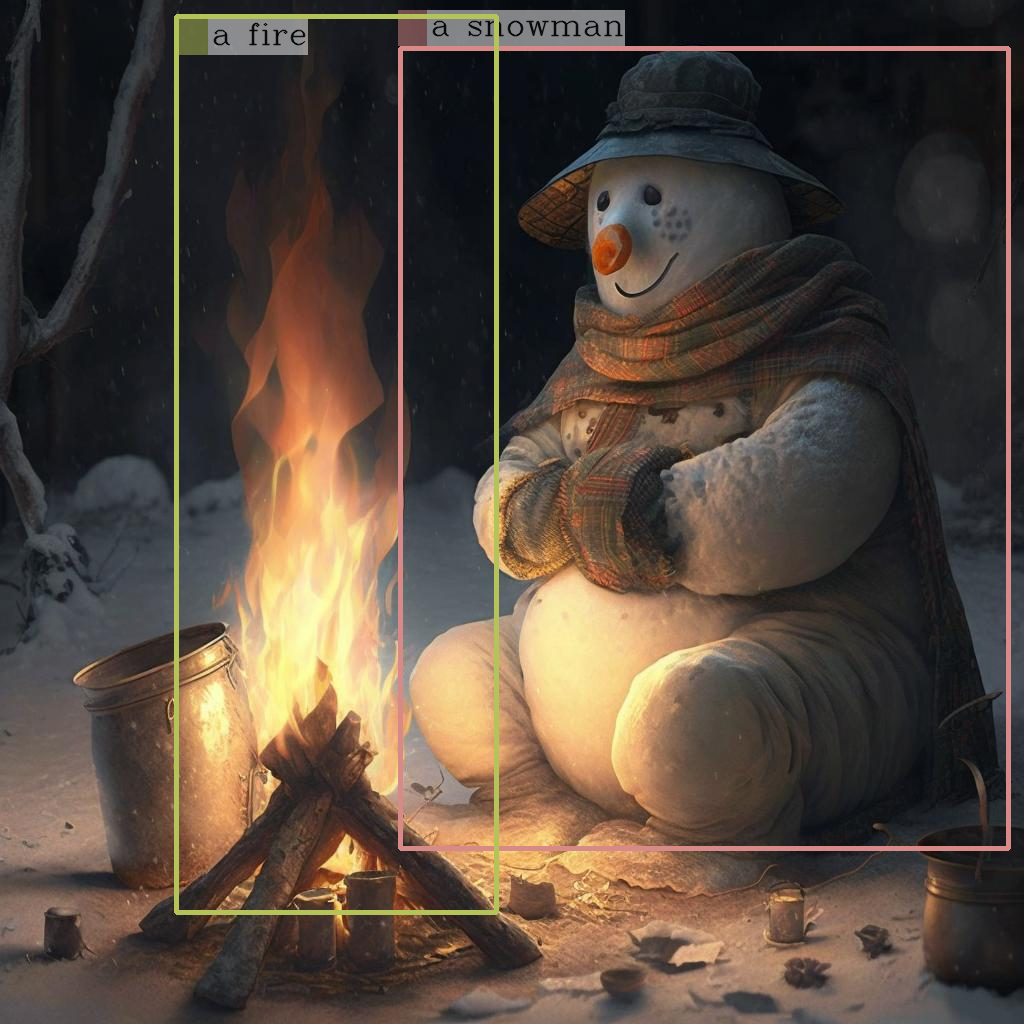

In [25]:
# Draw the bounding bboxes
new_image = draw_entity_boxes_on_image(image, entities)
display(new_image)

## Convert models to OpenVINO Intermediate representation (IR) format
[back to top ⬆️](#Table-of-contents:)

The original model includes 3 models: vision model `Kosmos2VisionModel`, `Kosmos2ImageToTextProjection` that is the layer that transforms the image model's output to part of the text model's input (namely, image features), and transformer based text model `Kosmos2TextForCausalLM`. We will convert all of them and then replace the original models.

Define paths for converted models:

In [26]:
from pathlib import Path


models_base_folder = Path("models")
VISION_MODEL_IR_PATH = models_base_folder / "vision_model.xml"
IMAGE_TO_TEXT_PROJECTION_MODEL_IR_PATH = models_base_folder / "image_to_text_projection_model.xml"
FIRST_STAGE_MODEL_PATH = models_base_folder / "kosmos_input_embed.xml"
SECOND_STAGE_MODEL_PATH = models_base_folder / "kosmos_with_past.xml"

Define the conversion function for PyTorch modules. We use `ov.convert_model` function to obtain OpenVINO Intermediate Representation object and `ov.save_model` function to save it as XML file.

In [27]:
import gc

import torch

import openvino as ov


def cleanup_torchscript_cache():
    # cleanup memory
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()

    gc.collect()


def convert(model: torch.nn.Module, xml_path: str, example_input):
    xml_path = Path(xml_path)
    if not xml_path.exists():
        xml_path.parent.mkdir(parents=True, exist_ok=True)
        with torch.no_grad():
            converted_model = ov.convert_model(model, example_input=example_input)
        ov.save_model(converted_model, xml_path, compress_to_fp16=False)
        
        cleanup_torchscript_cache()

### Convert the vision model
[back to top ⬆️](#Table-of-contents:)

Vision model accept `pixel_values` and returns `image_embeds`.

In [28]:
convert(model.vision_model, VISION_MODEL_IR_PATH, inputs["pixel_values"])

### Convert Image To Text Projection model
[back to top ⬆️](#Table-of-contents:)

In [29]:
from torch import nn


def get_image_embeds(pixel_values):
    vision_model_output = model.vision_model(pixel_values)
    image_embeds = model.vision_model.model.post_layernorm(vision_model_output[0])
    image_embeds = nn.functional.normalize(image_embeds, dim=-1)

    return image_embeds


image_embeds = get_image_embeds(inputs["pixel_values"])
convert(model.image_to_text_projection, IMAGE_TO_TEXT_PROJECTION_MODEL_IR_PATH, image_embeds)

### Convert Text model 
[back to top ⬆️](#Table-of-contents:)

The Text Model performs in generation pipeline and we can separate it into two stage. In the first stage the model transforms `image_embeds` into output for the second stage. In the second stage the model produces tokens during several runs that can be transformed into raw model generated text by `AutoProcessor`.

In [30]:
from typing import Optional, List

from transformers.models.kosmos2.modeling_kosmos2 import create_position_ids_from_input_ids


def get_projecton_image_embeds(pixel_values):
    vision_model_output = model.vision_model(pixel_values)
    image_embeds = model.vision_model.model.post_layernorm(vision_model_output[0])
    image_embeds = nn.functional.normalize(image_embeds, dim=-1)
    image_embeds, _ = model.image_to_text_projection(image_embeds)

    return image_embeds


def flattenize_inputs(inputs):
    """
    Helper function for making nested inputs flattens
    """
    flatten_inputs = []
    for input_data in inputs:
        if input_data is None:
            continue
        if isinstance(input_data, (list, tuple)):
            flatten_inputs.extend(flattenize_inputs(input_data))
        else:
            flatten_inputs.append(input_data)
    return flatten_inputs


def postprocess_converted_model(ov_model, example_input=None, input_names=None, output_names=None, dynamic_shapes=None):
    """
    Helper function for appling postprocessing on converted model with updating input names, shapes and output names
    acording to requested specification
    """

    flatten_example_inputs = flattenize_inputs(example_input) if example_input else []
    if input_names:
        for inp_name, m_input, input_data in zip(input_names, ov_model.inputs, flatten_example_inputs):
            m_input.get_tensor().set_names({inp_name})
    
    if output_names:
        for out, out_name in zip(ov_model.outputs, output_names):
            out.get_tensor().set_names({out_name})

    return ov_model


def convert_text_model():
    model.text_model.model.config.torchscript = True
    model.text_model.config.torchscript = True
    image_embeds = get_projecton_image_embeds(inputs["pixel_values"])
    conv_inputs = {
        'input_ids': inputs["input_ids"],
        'attention_mask': inputs["attention_mask"],
        'image_embeds': image_embeds,
        'image_embeds_position_mask': inputs["image_embeds_position_mask"],
    }
    outs = model.text_model.model(**conv_inputs)
    inputs_ = ["input_ids", 'attention_mask']
    outputs = ["logits"]
    dynamic_shapes = {"input_ids": {1: "seq_len"}, "attention_mask": {1: "seq_len"}, "position_ids": {0: "seq_len"}}
    for idx in range(len(outs[1])):
        inputs_.extend([f"past_key_values.{idx}.key", f"past_key_values.{idx}.value"])
        dynamic_shapes[inputs_[-1]] = {2: "past_sequence + sequence"}
        dynamic_shapes[inputs_[-2]] = {2: "past_sequence + sequence"}
        outputs.extend([f"present.{idx}.key", f"present.{idx}.value"])

    if not FIRST_STAGE_MODEL_PATH.exists():
        ov_model = ov.convert_model(model.text_model.model, example_input=conv_inputs)
        ov_model = postprocess_converted_model(ov_model, output_names=outputs)
        ov.save_model(ov_model, FIRST_STAGE_MODEL_PATH)
        del ov_model
        cleanup_torchscript_cache()

    if not SECOND_STAGE_MODEL_PATH.exists():
        position_ids = create_position_ids_from_input_ids(
            inputs["input_ids"],
            padding_idx=model.text_model.config.pad_token_id,
            past_key_values_length=0,
        )[:, -1:]

        example_input_second_stage = {
            "input_ids": inputs["input_ids"][:, -1:],
            "attention_mask": inputs["input_ids"].new_ones(1, inputs["input_ids"].shape[1] + 1),
            'position_ids': position_ids,
            "past_key_values": outs[1],
        }
        
        ov_model = ov.convert_model(model.text_model.model, example_input=example_input_second_stage)
        ov_model = postprocess_converted_model(
            ov_model, 
            example_input=example_input_second_stage.values(), 
            input_names=inputs_, 
            output_names=outputs, 
            dynamic_shapes=dynamic_shapes
        )
        ov.save_model(ov_model, SECOND_STAGE_MODEL_PATH)
        del ov_model
        cleanup_torchscript_cache()


convert_text_model()     

## Compiling models and prepare pipeline
[back to top ⬆️](#Table-of-contents:)

Select device that will be used to do models inference using OpenVINO from the dropdown list:

In [31]:
import ipywidgets as widgets


core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

Let's create callable wrapper classes for compiled models to allow interaction with original pipeline. Note that all of wrapper classes return `torch.Tensor`s instead of `np.array`s.

In [32]:
class WraperInternalVisionModel:
    post_layernorm = model.vision_model.model.post_layernorm
    

class VisionModelWrapper(torch.nn.Module):
    def __init__(self, model_ir_path):
        super().__init__()
        self.model = WraperInternalVisionModel()
        self.vision_model = core.compile_model(model_ir_path, device.value)

    def forward(self, pixel_values, **kwargs):
        vision_model_output = self.vision_model(pixel_values)[0]

        return [torch.from_numpy(vision_model_output)]
    

class ImageToTextProjectionModelWrapper(torch.nn.Module):
    def __init__(self, model_ir_path):
        super().__init__()
        self.image_to_text_projection = core.compile_model(model_ir_path, device.value)

    def forward(self, image_embeds):
        output = self.image_to_text_projection(image_embeds)
        image_embeds = output[0]
        projection_attentions = output[1]
        return image_embeds, projection_attentions

In [33]:
from transformers.generation import GenerationConfig, GenerationMixin
from transformers.models.kosmos2.modeling_kosmos2 import Kosmos2ForConditionalGenerationModelOutput


class KosmosForCausalLMWrapper(GenerationMixin):
    def __init__(self, first_stage_model_path, second_stage_model_path, device):
        
        self.model_stage_1 = core.compile_model(first_stage_model_path, device.value)
        self.model_stage_2 = core.read_model(second_stage_model_path)
        self.input_names = {
            key.get_any_name(): idx for idx, key in enumerate(self.model_stage_2.inputs)
        }
        self.output_names = {
            key.get_any_name(): idx for idx, key in enumerate(self.model_stage_2.outputs)
        }
        self.key_value_input_names = [
            key for key in self.input_names if "key_values" in key
        ]
        self.key_value_output_names = [
            key for key in self.output_names if "present" in key
        ]
        self.model_stage_2 = core.compile_model(self.model_stage_2, device.value)

        self.request = self.model_stage_2.create_infer_request()
        self.config = model.config
        self.generation_config = GenerationConfig.from_model_config(model.config)
        self.main_input_name = "input_ids"
        self.device = torch.device("cpu")
        self.num_pkv = 2
        self.lm_head = nn.Linear(in_features=model.text_model.config.embed_dim, out_features=model.text_model.config.vocab_size, bias=False)

    def get_input_embeddings(self) -> nn.Module:
        return self.model.embed_tokens

    def set_input_embeddings(self, value):
        self.model.embed_tokens = value

    def get_output_embeddings(self) -> nn.Module:
        return self.lm_head

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    def can_generate(self):
        """Returns True to validate the check that the model using `GenerationMixin.generate()` can indeed generate."""
        return True

    def __call__(
        self,
        input_ids,
        attention_mask: Optional[torch.Tensor] = None,
        image_embeds: Optional[torch.Tensor] = None,
        image_embeds_position_mask: Optional[torch.Tensor] = None,
        position_ids=None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        **kwargs,
    ):
        return self.forward(
            input_ids, attention_mask, image_embeds, image_embeds_position_mask, position_ids, past_key_values
        )

    def forward(
        self,
        input_ids,
        attention_mask: Optional[torch.Tensor] = None,
        image_embeds: Optional[torch.Tensor] = None,
        image_embeds_position_mask: Optional[torch.Tensor] = None,
        position_ids=None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        
        **kwargs
    ):
        if past_key_values is None:
            
            outs = self.model_stage_1(
                {
                    'input_ids': input_ids,
                    'attention_mask': attention_mask,
                    'image_embeds': image_embeds,
                    'image_embeds_position_mask': image_embeds_position_mask,
                }
            )            
            lm_logits = model.text_model.lm_head(torch.from_numpy(outs[0]))

            pkv = list(outs.values())[1:]
            pkv = tuple(pkv[i : i + 2] for i in range(0, len(pkv), 2))

            return Kosmos2ForConditionalGenerationModelOutput(logits=lm_logits, past_key_values=pkv)
        
        if past_key_values is not None:
            past_key_values = tuple(
                past_key_value
                for pkv_per_layer in past_key_values
                for past_key_value in pkv_per_layer
            )
            inputs_ = {
                "input_ids": input_ids[:, -1].unsqueeze(-1),
                "attention_mask": attention_mask,
                'position_ids': position_ids
            }
            inputs_.update(dict(zip(self.key_value_input_names, past_key_values)))

        # Run inference
        self.request.start_async(inputs_, share_inputs=True)
        self.request.wait()

        logits = torch.from_numpy(self.request.get_tensor("logits").data)
        logits = model.text_model.lm_head(logits)

        # Tuple of length equal to : number of layer * number of past_key_value per decoder layer (2 corresponds to the self-attention layer)
        past_key_values = tuple(
            self.request.get_tensor(key).data for key in self.key_value_output_names
        )
        # Tuple of tuple of length `n_layers`, with each tuple of length equal to 2 (k/v of self-attention)

        past_key_values = tuple(
            past_key_values[i : i + self.num_pkv]
            for i in range(0, len(past_key_values), self.num_pkv)
        )
        
        return Kosmos2ForConditionalGenerationModelOutput(logits=logits, past_key_values=past_key_values)


    def prepare_inputs_for_generation(
        self,
        input_ids,
        image_embeds=None,
        image_embeds_position_mask=None,
        past_key_values=None,
        attention_mask=None,
        use_cache=None,
        **kwargs,
    ):
        input_shape = input_ids.shape
        # if model is used as a decoder in encoder-decoder model, the decoder attention mask is created on the fly
        if attention_mask is None:
            attention_mask = input_ids.new_ones(input_shape)

        position_ids = None

        # cut input_ids if past_key_values is used
        if past_key_values is not None:
            position_ids = create_position_ids_from_input_ids(
                input_ids,
                padding_idx=model.text_model.config.pad_token_id,
                past_key_values_length=0,
            )[:, -1:]

            input_ids = input_ids[:, -1:]
            image_embeds = None
            image_embeds_position_mask = None
        elif image_embeds_position_mask is not None:
            batch_size, seq_len = input_ids.size()
            mask_len = image_embeds_position_mask.size()[-1]
            image_embeds_position_mask = torch.cat(
                (
                    image_embeds_position_mask,
                    torch.zeros(size=(batch_size, seq_len - mask_len), dtype=torch.bool, device=input_ids.device),
                ),
                dim=1,
            )

        return {
            "input_ids": input_ids,
            "image_embeds": image_embeds,
            "image_embeds_position_mask": image_embeds_position_mask,
            'position_ids': position_ids,
            "past_key_values": past_key_values,
            "attention_mask": attention_mask,
        }
    
    @staticmethod
    # Copied from transformers.models.umt5.modeling_umt5.UMT5ForConditionalGeneration._reorder_cache
    def _reorder_cache(past_key_values, beam_idx):
        reordered_past = ()
        for layer_past in past_key_values:
            reordered_past += (
                tuple(past_state.index_select(0, beam_idx.to(past_state.device)) for past_state in layer_past),
            )
        return reordered_past


class Kosmos2ForConditionalGenerationWrapper:
    
    def __init__(self, vision_model_path, image_to_text_projection_model_path, first_stage_model_path, second_stage_model_path, device):
        self.vision_model = VisionModelWrapper(vision_model_path)
        self.image_to_text_projection = ImageToTextProjectionModelWrapper(image_to_text_projection_model_path)
        self.text_model = KosmosForCausalLMWrapper(first_stage_model_path, second_stage_model_path, device)

    def generate(
        self,
        pixel_values=None,
        image_embeds_position_mask=None,
        input_ids=None,
        attention_mask=None,
        image_embeds=None,
        **kwargs,
    ):
        vision_model_output = self.vision_model(pixel_values)
        image_embeds = model.vision_model.model.post_layernorm(vision_model_output[0])
        # normalized features
        image_embeds = nn.functional.normalize(image_embeds, dim=-1)
        image_embeds, projection_attentions = self.image_to_text_projection(image_embeds.detach().numpy())

        output = self.text_model.generate(
            input_ids,
            attention_mask=attention_mask,
            image_embeds=image_embeds,
            image_embeds_position_mask=image_embeds_position_mask,
            **kwargs,
        )

        return output

In [34]:
ov_model = Kosmos2ForConditionalGenerationWrapper(VISION_MODEL_IR_PATH, IMAGE_TO_TEXT_PROJECTION_MODEL_IR_PATH, FIRST_STAGE_MODEL_PATH, SECOND_STAGE_MODEL_PATH, device)

## Inference
[back to top ⬆️](#Table-of-contents:)

In [35]:
generated_ids_ = ov_model.generate(
    pixel_values=inputs["pixel_values"],
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    image_embeds=None,
    image_embeds_position_mask=inputs["image_embeds_position_mask"],
    max_new_tokens=128,
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Specify `cleanup_and_extract=False` in order to see the raw model generation.
processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
print(f'Raw model generation: {processed_text}')
# `<grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming himself by<phrase> a fire</phrase><object><patch_index_0005><patch_index_0911></object>.`

# By default, the generated  text is cleanup and the entities are extracted.
processed_text, entities = processor.post_process_generation(generated_text)

print(f'Cleaned up generated text: {processed_text=}')
# `An image of a snowman warming himself by a fire.`

print(f'Extracted entities: {entities}')
# `[('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a fire', (41, 47), [(0.171875, 0.015625, 0.484375, 0.890625)])]`

Raw model generation: <grounding> An image of<phrase> a snowman</phrase><object><patch_index_0044><patch_index_0863></object> warming himself by<phrase> a fire</phrase><object><patch_index_0005><patch_index_0911></object>.
Cleaned up generated text: processed_text='An image of a snowman warming himself by a fire.'
Extracted entities: [('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a fire', (41, 47), [(0.171875, 0.015625, 0.484375, 0.890625)])]


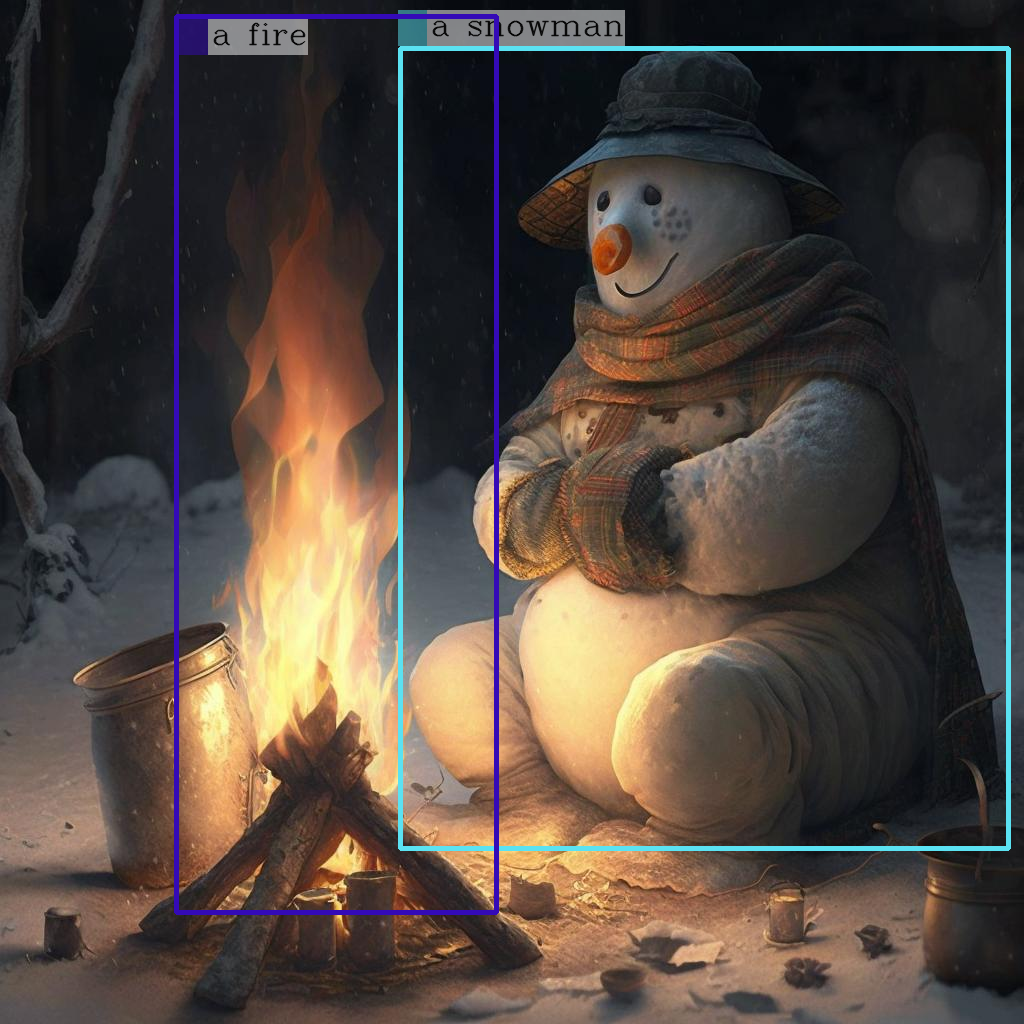

In [36]:
new_image = draw_entity_boxes_on_image(image, entities)
display(new_image)

## Interactive inference
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import gradio as gr


images = {
    "snowman.png": "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.png",
    "two_dogs.jpg": "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/two_dogs.jpg",
    "six_planes.png": "https://ydshieh-kosmos-2.hf.space/file=/home/user/app/images/six_planes.png"
}
for image_name, url in images.items():
    image = Image.open(requests.get(url, stream=True).raw)
    image.save(image_name)


def generate(image, prompt, use_bbox, _=gr.Progress(track_tqdm=True)):
    if use_bbox:
        prompt = "<grounding> " + prompt
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids_ = ov_model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        max_new_tokens=128,
    )
    generated_text = processor.batch_decode(generated_ids_, skip_special_tokens=True)[0]
    processed_text, entities = processor.post_process_generation(generated_text)

    new_image = draw_entity_boxes_on_image(Image.fromarray(image), entities)
    
    return new_image, processed_text


demo = gr.Interface(
    generate,
    [
        gr.Image(label="Input image"),
        gr.Textbox(label="Prompt"),
        gr.Checkbox(label="Show bounding boxes", value=True)
    ],
    ["image", "text"],
    examples=[
        ["snowman.png", "An image of"],
        ["two_dogs.jpg", "Describe this image in detail:"],
        ["six_planes.png", "What is going on?"]
    ],
    allow_flagging="never",
)
try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/